## Introduction: Disney Stock Price Prediction

In this project, we will be first analyzing the trends in the stock price of 'The Walt Disney Company' from it's opening date in 1962 to it's current.

We will be using 2 models to compare results in predicting the trends in this stock. Facebook Prophet and Tenseroflow.

In [96]:
#Importing the neccesssary libraries
import datetime as datetime
import numpy as np
import pandas as pd
import pandas_datareader as web

#plotting libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

#prediction model libraries
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima 

import fbprophet as Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [122]:
#reading the dataset and assigning it to a dataframe
company = 'DIS'
dis = web.DataReader(company, 'yahoo', start, end)
#dis = pd.read_csv('DIS.csv', index_col='Date',parse_dates=True)
dis 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1970-01-02,0.689779,0.683357,0.688495,0.683357,1109377.0,0.454785
1970-01-05,0.688495,0.662805,0.683357,0.662805,1440243.0,0.441107
1970-01-06,0.655098,0.646106,0.655098,0.649960,3503294.0,0.432559
1970-01-07,0.670512,0.652529,0.652529,0.666658,5741510.0,0.443671
1970-01-08,0.692348,0.673081,0.673081,0.683357,2316067.0,0.454785
...,...,...,...,...,...,...
2021-02-09,189.250000,186.039993,188.169998,188.210007,11270800.0,188.210007
2021-02-10,190.699997,185.809998,189.979996,189.630005,11464600.0,189.630005
2021-02-11,191.250000,188.070007,189.179993,190.910004,17325200.0,190.910004


In [123]:
dis.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12896 entries, 1970-01-02 to 2021-02-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       12896 non-null  float64
 1   Low        12896 non-null  float64
 2   Open       12896 non-null  float64
 3   Close      12896 non-null  float64
 4   Volume     12896 non-null  float64
 5   Adj Close  12896 non-null  float64
dtypes: float64(6)
memory usage: 705.2 KB


We verify that there are no missing values.

In [124]:
dis.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

We first look at the first 10 entries when the stock opened of trading in January 2, 1962 until January 15, 1962

In [125]:
dis.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1970-01-02,0.689779,0.683357,0.688495,0.683357,1109377.0,0.454785
1970-01-05,0.688495,0.662805,0.683357,0.662805,1440243.0,0.441107
1970-01-06,0.655098,0.646106,0.655098,0.649960,3503294.0,0.432559
1970-01-07,0.670512,0.652529,0.652529,0.666658,5741510.0,0.443671
1970-01-08,0.692348,0.673081,0.673081,0.683357,2316067.0,0.454785
1970-01-09,0.706478,0.688495,0.688495,0.697486,1868424.0,0.464188
1970-01-12,0.716754,0.700055,0.700055,0.714185,1323467.0,0.475301
1970-01-13,0.760427,0.720607,0.720607,0.745013,2744247.0,0.495818
1970-01-14,0.795109,0.749509,0.749509,0.782264,7687785.0,0.520609


As of the last information on this dataset, we also look at the tail end of the entries. Feb 1, 2021 to Feb 12, 2021. This dates may change as we update the table with newer entries.

In [126]:
dis.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-02-02,179.759995,172.800003,173.770004,176.960007,12215200.0,176.960007
2021-02-03,178.429993,175.759995,177.000000,176.429993,5508600.0,176.429993
2021-02-04,181.380005,176.490005,177.589996,180.229996,9035400.0,180.229996
2021-02-05,182.320007,179.330002,181.710007,181.160004,6597700.0,181.160004
2021-02-08,190.639999,183.300003,183.850006,190.000000,16085700.0,190.000000
2021-02-09,189.250000,186.039993,188.169998,188.210007,11270800.0,188.210007
2021-02-10,190.699997,185.809998,189.979996,189.630005,11464600.0,189.630005
2021-02-11,191.250000,188.070007,189.179993,190.910004,17325200.0,190.910004
2021-02-12,193.850006,186.559998,193.000000,187.669998,27200900.0,187.669998


In [127]:
#The earliest date is 1/2/1962
print(dis.index.min())
#The latest date is 2/12/2021
print(dis.index.max())

1970-01-02 00:00:00
2021-02-16 00:00:00


In [128]:
dis['Close'].iplot(title='Historical Trend of the Disney Stock',
                  xTitle='Year',
                  yTitle='Stock Price')
plt.show()

Since we are looking at the the stock performance on a daily basis, we will only be looking at the 'Close' column / feature for now.

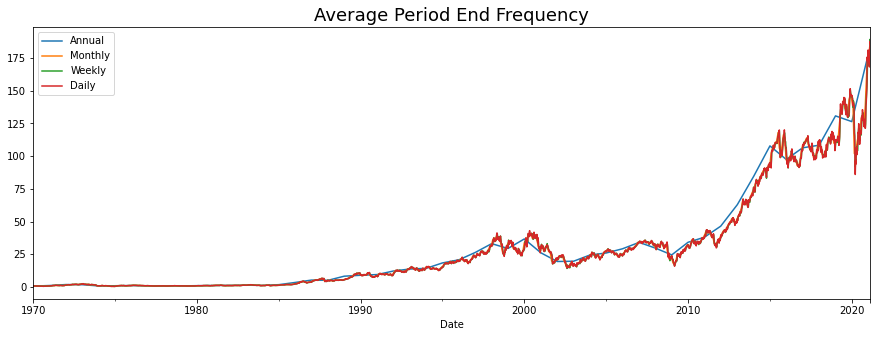

In [129]:
# Getting the average yearly end frequency
plt.figure(figsize=(15,5))

dis['Close'].resample(rule='A').mean().plot()
dis['Close'].resample('M').mean().plot()
dis['Close'].resample('W').mean().plot()
dis['Close'].resample('D').mean().plot()
plt.title('Average Period End Frequency', fontsize=18, ha='center')
plt.legend(labels=('Annual', 'Monthly', 'Weekly', 'Daily'))
plt.show()

As we can see with the period average patterns above, the trends are consistent with each other.

Next, we create a rolling mean window every 30 days for stock closing price. We can see below that the trends seems very consistent with one another.

In [130]:
dis['Close'].rolling(window=30).mean().iplot()

### Statsmodels

#### Cycles and Trends

Using the Hodrick–Prescott filter, we will assign a lambda of 129600 which signifies an annual ratio of data. Through this method, we will separate any cycles and trends for further insight.

In [131]:
dis_cycle, dis_trend = hpfilter(dis['Close'], lamb=129600)

In [132]:
dis['close_cycle'] = dis_cycle
dis['close_trend'] = dis_trend

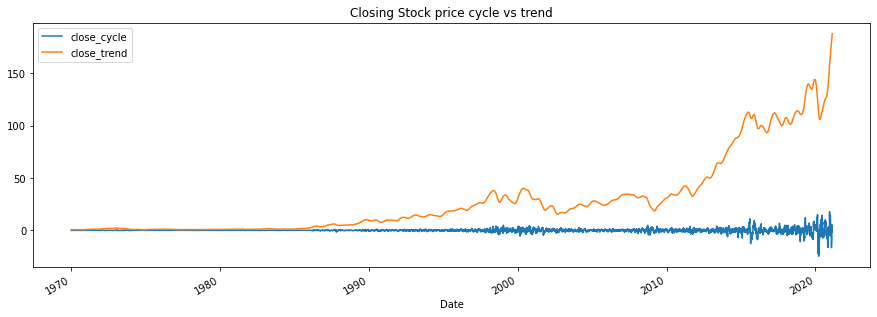

In [133]:
dis[['close_cycle', 'close_trend']].plot(figsize=(15,5))
plt.title('Closing Stock price cycle vs trend')
plt.show()

Looking at the plot below, we can also see the trend in closing prices after Disneys major acquisition of the Star Wars and Marvel franchises.

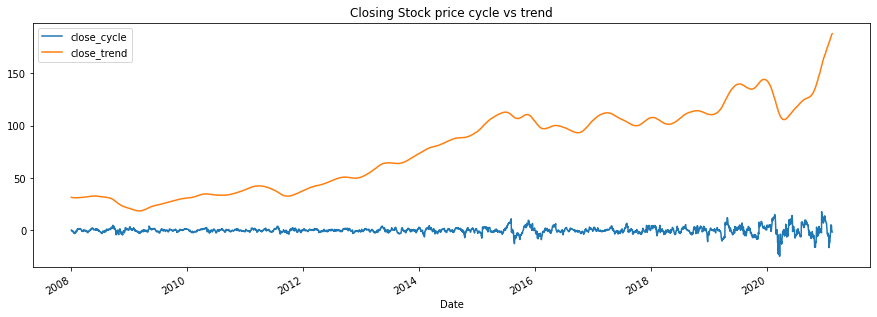

In [134]:
dis[['close_cycle', 'close_trend']]['2008-01-01':].plot(figsize=(15,5))
plt.title('Closing Stock price cycle vs trend')
plt.show()

#### ETS Decomposition

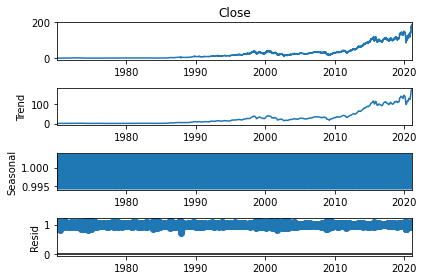

In [135]:
decompose_result = seasonal_decompose(dis['Close'], period=30,
                                     model='multiplicative')
decompose_result.plot();

## Forecasting

### Facebook Prophet

In [137]:
dis

,High,Low,Open,Close,Volume,Adj Close,close_cycle,close_trend
Date,,,,,,,,
1970-01-02,0.689779,0.683357,0.688495,0.683357,1109377.0,0.454785,-0.050801,0.734158
1970-01-05,0.688495,0.662805,0.683357,0.662805,1440243.0,0.441107,-0.071994,0.734799
1970-01-06,0.655098,0.646106,0.655098,0.649960,3503294.0,0.432559,-0.085480,0.735440
1970-01-07,0.670512,0.652529,0.652529,0.666658,5741510.0,0.443671,-0.069421,0.736079
1970-01-08,0.692348,0.673081,0.673081,0.683357,2316067.0,0.454785,-0.053358,0.736715
...,...,...,...,...,...,...,...,...
2021-02-09,189.250000,186.039993,188.169998,188.210007,11270800.0,188.210007,2.870259,185.339748
2021-02-10,190.699997,185.809998,189.979996,189.630005,11464600.0,189.630005,3.639963,185.990042
2021-02-11,191.250000,188.070007,189.179993,190.910004,17325200.0,190.910004,4.269665,186.640338


In [139]:
dis.reset_index(inplace=True)

In [140]:
dis = dis[['Date', 'Close']]
dis.columns = ['ds', 'y']
dis.head()

,ds,y
0,1970-01-02,0.683357
1,1970-01-05,0.662805
2,1970-01-06,0.649960
3,1970-01-07,0.666658
4,1970-01-08,0.683357


In [141]:
dis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12896 entries, 0 to 12895
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      12896 non-null  datetime64[ns]
 1   y       12896 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 201.6 KB


In [142]:
dis['ds'] = pd.to_datetime(dis['ds'])
dis.head()

,ds,y
0,1970-01-02,0.683357
1,1970-01-05,0.662805
2,1970-01-06,0.649960
3,1970-01-07,0.666658
4,1970-01-08,0.683357


In [143]:
dis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12896 entries, 0 to 12895
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      12896 non-null  datetime64[ns]
 1   y       12896 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 201.6 KB


In [144]:
model = Prophet.Prophet()
model.fit(dis)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [145]:
future = model.make_future_dataframe(periods=24, freq='MS')

In [146]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12920 entries, 0 to 12919
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      12920 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 101.1 KB


In [147]:
model.predict(future)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-02,0.870207,-5.489109,9.163077,0.870207,0.870207,0.778487,0.778487,0.778487,0.005678,0.005678,0.005678,0.772809,0.772809,0.772809,0.0,0.0,0.0,1.648693
1,1970-01-05,0.871165,-5.460759,9.214911,0.871165,0.871165,0.819702,0.819702,0.819702,0.045244,0.045244,0.045244,0.774458,0.774458,0.774458,0.0,0.0,0.0,1.690868
2,1970-01-06,0.871485,-6.219889,9.019204,0.871485,0.871485,0.840802,0.840802,0.840802,0.074250,0.074250,0.074250,0.766552,0.766552,0.766552,0.0,0.0,0.0,1.712287
3,1970-01-07,0.871804,-5.463579,9.077222,0.871804,0.871804,0.794778,0.794778,0.794778,0.039996,0.039996,0.039996,0.754782,0.754782,0.754782,0.0,0.0,0.0,1.666583
4,1970-01-08,0.872124,-5.462596,9.234067,0.872124,0.872124,0.762585,0.762585,0.762585,0.023067,0.023067,0.023067,0.739518,0.739518,0.739518,0.0,0.0,0.0,1.634708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12915,2022-10-01,161.442938,151.686599,167.717067,158.898614,163.420874,-1.511487,-1.511487,-1.511487,-0.094118,-0.094118,-0.094118,-1.417370,-1.417370,-1.417370,0.0,0.0,0.0,159.931451
12916,2022-11-01,162.326539,153.402073,170.008059,159.485995,164.519012,-0.908682,-0.908682,-0.908682,0.074250,0.074250,0.074250,-0.982932,-0.982932,-0.982932,0.0,0.0,0.0,161.417857
12917,2022-12-01,163.181637,155.289694,171.250911,160.105405,165.659958,0.261163,0.261163,0.261163,0.023067,0.023067,0.023067,0.238097,0.238097,0.238097,0.0,0.0,0.0,163.442800
12918,2023-01-01,164.065237,155.771217,172.687584,160.740558,166.728352,0.666511,0.666511,0.666511,-0.094118,-0.094118,-0.094118,0.760628,0.760628,0.760628,0.0,0.0,0.0,164.731748


In [148]:
forecast = model.predict(future)

In [149]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [150]:
forecast[['ds','yhat_lower','yhat_upper','yhat']].tail(24)

,ds,yhat_lower,yhat_upper,yhat
12896,2021-03-01,137.728684,152.967154,145.234603
12897,2021-04-01,137.782844,153.207781,145.456146
12898,2021-05-01,139.142244,154.556539,147.211851
12899,2021-06-01,140.586134,155.842007,148.298681
12900,2021-07-01,140.582252,156.392032,148.545852
12901,2021-08-01,142.118165,157.096849,149.386117
12902,2021-09-01,141.896652,157.615718,149.574849
12903,2021-10-01,142.401694,157.468879,149.623672
12904,2021-11-01,143.640437,158.565382,150.992587
12905,2021-12-01,145.264944,160.219367,153.058366


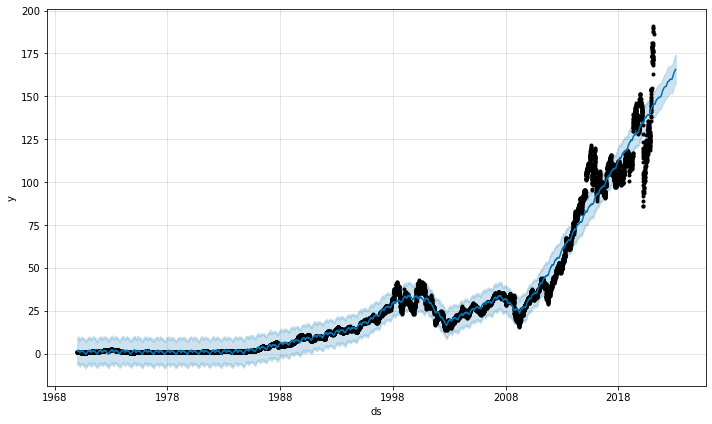

In [151]:
model.plot(forecast);

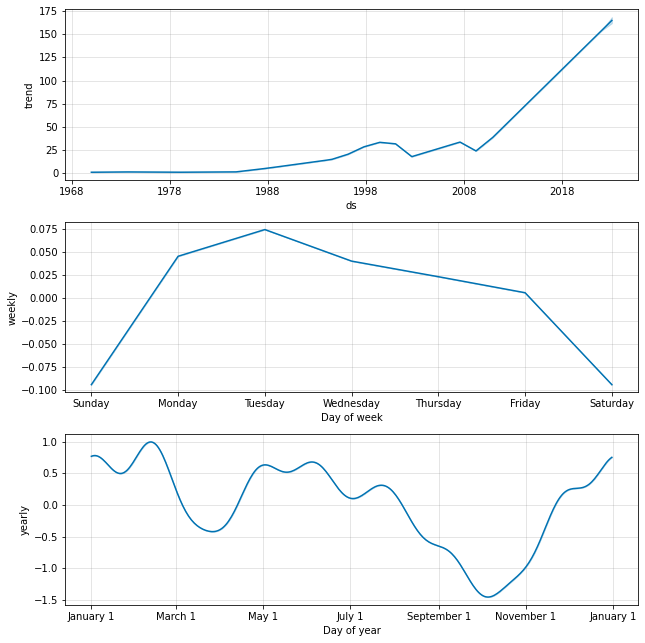

In [152]:
model.plot_components(forecast);

#### Evaluating Prophet Model

In [153]:
train = dis.iloc[:-1]
test = dis.iloc[0:]

In [154]:
model2 = Prophet.Prophet()
model2.fit(train)
future = model2.make_future_dataframe(periods=12, freq='MS')
forecast = model2.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


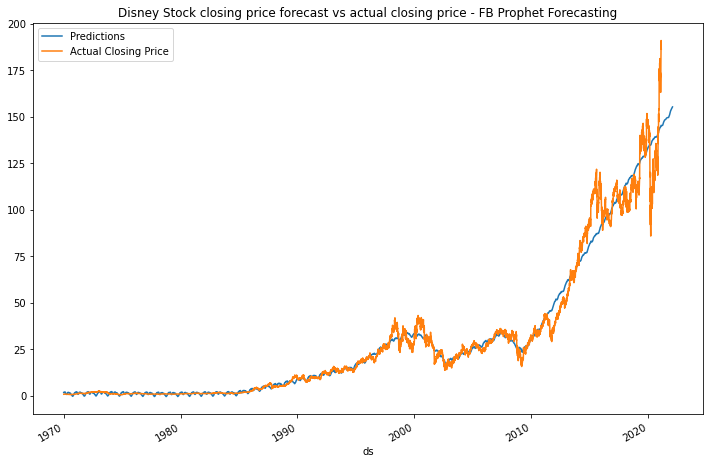

In [204]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))
test.plot(x='ds',y='y',label='Actual Closing Price',legend=True,ax=ax)
plt.title('Disney Stock closing price forecast vs actual closing price - FB Prophet Forecasting')
plt.show()

In [156]:
prediction = forecast['yhat']
prediction

0          1.725820
1          1.765707
2          1.772233
3          1.741949
4          1.711290
            ...    
12902    149.502825
12903    150.866517
12904    152.927881
12905    154.147087
12906    155.192032
Name: yhat, Length: 12907, dtype: float64

In [157]:
test.mean()

y    28.522318
dtype: float64

In [158]:
# Initial 5 years training period
initial = 5 * 365
initial = str(initial) + ' days'
# Fold every 5 years
period = 5 * 365
period = str(period) + ' days'
# Forecast 1 year into the future
horizon = 365
horizon = str(horizon) + ' days'

In [159]:
dis_cv = cross_validation(model2, initial=initial, period=period, horizon = horizon)

INFO:fbprophet:Making 10 forecasts with cutoffs between 1975-02-24 00:00:00 and 2020-02-13 00:00:00


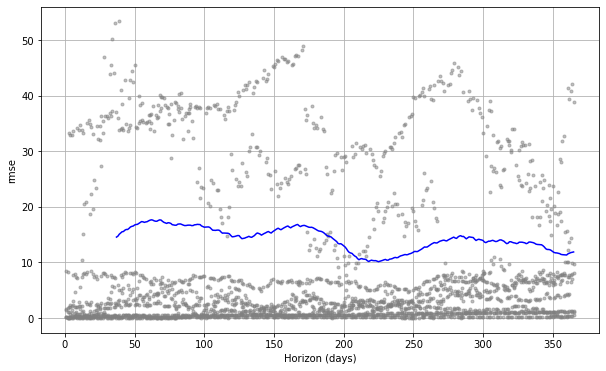

In [160]:
plot_cross_validation_metric(dis_cv, metric='rmse');

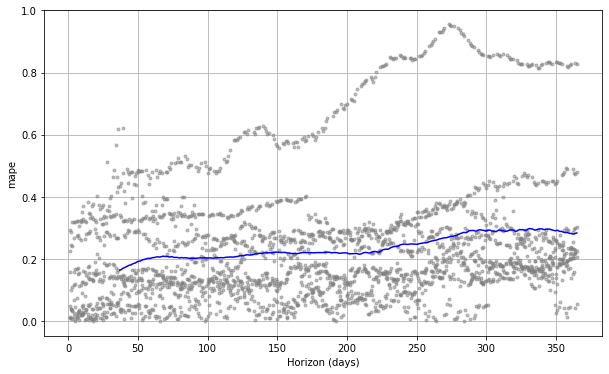

In [161]:
plot_cross_validation_metric(dis_cv, metric='mape');

### ARIMA

In [162]:
dis

,ds,y
0,1970-01-02,0.683357
1,1970-01-05,0.662805
2,1970-01-06,0.649960
3,1970-01-07,0.666658
4,1970-01-08,0.683357
...,...,...
12891,2021-02-09,188.210007
12892,2021-02-10,189.630005
12893,2021-02-11,190.910004
12894,2021-02-12,187.669998


In [163]:
auto_arima(dis['Close'],seasonal=True).summary()

KeyError: 'Close'

In [ ]:
train = dis.iloc[:14882]
test = dis.iloc[14882:]

In [ ]:
stepwise_fit = auto_arima(dis['Close'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)         

stepwise_fit.summary()

In [ ]:
model = ARIMA(train['Close'],order=(1,1,1))
results = model.fit()
results.summary()

### Deep Learning

In [168]:
company = 'DIS'
dis = web.DataReader(company, 'yahoo', start, end)
dis

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1970-01-02,0.689779,0.683357,0.688495,0.683357,1109377.0,0.454785
1970-01-05,0.688495,0.662805,0.683357,0.662805,1440243.0,0.441107
1970-01-06,0.655098,0.646106,0.655098,0.649960,3503294.0,0.432559
1970-01-07,0.670512,0.652529,0.652529,0.666658,5741510.0,0.443671
1970-01-08,0.692348,0.673081,0.673081,0.683357,2316067.0,0.454785
...,...,...,...,...,...,...
2021-02-09,189.250000,186.039993,188.169998,188.210007,11270800.0,188.210007
2021-02-10,190.699997,185.809998,189.979996,189.630005,11464600.0,189.630005
2021-02-11,191.250000,188.070007,189.179993,190.910004,17325200.0,190.910004


In [174]:
#Test Data
start = datetime.datetime(1970,1,1)
end = datetime.datetime(2020,1,1)

In [175]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dis['Close'].values.reshape(-1,1))

prediction_days = 30

In [176]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [177]:
#Model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #Next closing value prediction

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50, batch_size=20)

Epoch 1/50
12866/12866 [==============================] - 49s 4ms/sample - loss: 0.0012
Epoch 2/50
12866/12866 [==============================] - 42s 3ms/sample - loss: 5.7491e-04
Epoch 3/50
12866/12866 [==============================] - 41s 3ms/sample - loss: 5.0767e-04
Epoch 4/50
12866/12866 [==============================] - 42s 3ms/sample - loss: 4.9556e-04
Epoch 5/50
12866/12866 [==============================] - 43s 3ms/sample - loss: 4.6895e-04
Epoch 6/50
12866/12866 [==============================] - 43s 3ms/sample - loss: 4.2812e-04
Epoch 7/50
12866/12866 [==============================] - 41s 3ms/sample - loss: 3.9422e-04
Epoch 8/50
12866/12866 [==============================] - 41s 3ms/sample - loss: 4.1702e-04
Epoch 9/50
12866/12866 [==============================] - 41s 3ms/sample - loss: 4.0512e-04
Epoch 10/50
12866/12866 [==============================] - 41s 3ms/sample - loss: 4.0570e-04
Epoch 11/50
12866/12866 [==============================] - 40s 3ms/sample - loss: 4

In [184]:
#Model Accuracy
test_start = datetime.datetime(2020,1,1)
test_end = datetime.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_close = test_data['Close'].values

disney_df = pd.concat((dis['Close'], test_data['Close']), axis=0)

model_inputs = disney_df[len(disney_df) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)                      

In [188]:
#Predictions on Test

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_close = model.predict(x_test)
predicted_close = scaler.inverse_transform(predicted_close)

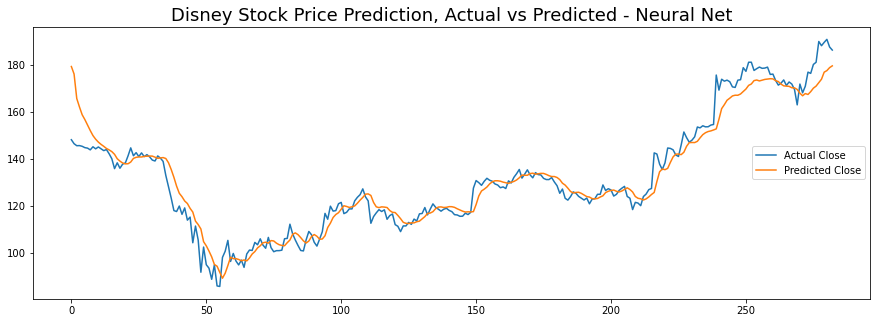

In [205]:
#Plot the Test Predictions
plt.figure(figsize=(15,5))
plt.plot(actual_close)
plt.plot(predicted_prices, '')
plt.legend(loc='right',labels=['Actual Close', 'Predicted Close'])
plt.title('Disney Stock Price Prediction, Actual vs Predicted - Neural Net', fontsize=18)
plt.show()

In [203]:
# Future Date

actual_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
actual_data = np.array(actual_data)
actual_data = np.reshape(acutal_data, (actual_data.shape[0], actual_data.shape[1], 1))

prediction = model.predict(actual_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction: {prediction}')

ValueError: Error when checking input: expected lstm_21_input to have shape (30, 1) but got array with shape (29, 1)